In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
from read_results import read_varnames
import saprc99_code.kpp4py as kpp

nvar = 74
varnames = read_varnames("saprc99_code/saprc99_Parameters.f90")[0:nvar]
print(varnames)

['H2SO4', 'HCOOH', 'CCO_OH', 'RCO_OH', 'CCO_OOH', 'RCO_OOH', 'XN', 'XC', 'SO2', 'O1D', 'ALK1', 'BACL', 'PAN', 'PAN2', 'PBZN', 'MA_PAN', 'H2O2', 'N2O5', 'HONO', 'ALK2', 'ALK3', 'TBU_O', 'ALK5', 'ARO2', 'HNO4', 'COOH', 'HOCOO', 'BZNO2_O', 'MEOH', 'ALK4', 'ARO1', 'DCB2', 'DCB3', 'CRES', 'DCB1', 'NPHE', 'ROOH', 'BALD', 'PHEN', 'CO', 'MGLY', 'ACET', 'HNO3', 'ETHENE', 'GLY', 'BZ_O', 'ISOPRENE', 'R2O2', 'TERP', 'METHACRO', 'OLE1', 'ISOPROD', 'OLE2', 'MVK', 'CCHO', 'HCHO', 'RNO3', 'O3P', 'RCHO', 'MEK', 'PROD2', 'O3', 'HO2', 'RO2_N', 'MA_RCO3', 'C_O2', 'BZCO_O2', 'RO2_R', 'NO', 'NO2', 'NO3', 'CCO_O2', 'RCO_O2', 'OH']


In [3]:
df_range = (
    pd.read_csv('saprc99_range.csv', index_col=0)
    .append(pd.DataFrame(np.array([[0.0, 1.0]]), 
                         columns=['min','max'], 
                         index=['SUN']
                        )
           )
)

df_range['mid'] = 0.5*(df_range['min']+df_range['max'])
df_range['span'] = df_range['max'] - df_range['min']
df_range.tail(10)

,min,max,mid,span
C_O2,5.391452e+06,1.419437e+09,7.124145e+08,1.414046e+09
BZCO_O2,1.000000e-08,3.226580e+06,1.613290e+06,3.226580e+06
RO2_R,2.006049e+05,1.824368e+09,9.122844e+08,1.824168e+09
NO,1.006610e+05,9.000156e+11,4.500078e+11,9.000155e+11
NO2,5.003760e+09,1.461165e+12,7.330842e+11,1.456161e+12
NO3,1.742790e+06,1.039629e+10,5.199017e+09,1.039455e+10
CCO_O2,6.779490e+05,5.267318e+08,2.637049e+08,5.260539e+08
RCO_O2,7.110903e+04,3.979400e+08,1.990056e+08,3.978689e+08
OH,9.784155e+04,7.272688e+07,3.641236e+07,7.262904e+07
SUN,0.000000e+00,1.000000e+00,5.000000e-01,1.000000e+00


# Make training data

In [4]:
y0_list = np.random.uniform(df_range['min'] + 0.3*df_range['span'],
                           df_range['max'] - 0.3*df_range['span'], 
                           size=(5000, nvar+1))

y0_list.shape

(5000, 75)

In [5]:
%time y1_list = kpp.onestep(y0_list.T).T
y1_list.shape

CPU times: user 3.62 s, sys: 36 ms, total: 3.66 s
Wall time: 3.68 s


(5000, 74)

# Normalize data

In [6]:
normalizer = StandardScaler()
normalizer.fit(y0_list[:,0:74])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [7]:
X_train = np.append(normalizer.transform(y0_list[:,0:74]), 
                    y0_list[:,-1:], 
                    axis=1)
X_train.shape

(5000, 75)

In [8]:
Y_train = normalizer.transform(y1_list)
Y_train.std(axis=0)

array([ 1.00075636,  1.00576225,  0.9999878 ,  0.99986502,  0.99994323,
        1.00001867,  1.10453182,  1.08862356,  0.98017753,  0.93158878,
        0.99466717,  1.06666927,  0.91152968,  0.94526614,  0.9961397 ,
        1.51796454,  0.95200396,  1.37113113,  0.21175688,  0.97822457,
        0.95274334,  0.96154752,  0.8522338 ,  0.67447781,  0.98312308,
        0.88898392,  0.88552487,  3.77650347,  0.98131332,  0.91979338,
        0.89303906,  0.922231  ,  1.1536837 ,  0.20718691,  0.62022981,
        1.25378411,  0.81276558,  0.74355956,  0.3383915 ,  0.99600056,
        0.7290046 ,  0.99992869,  1.00882806,  0.83001126,  0.74704249,
        0.64437324,  0.20270098,  0.60683657,  0.02492286,  0.62660832,
        0.54487708,  0.5132744 ,  0.08881151,  0.79993433,  0.75800346,
        0.7528092 ,  0.94200428,  0.75343238,  0.73272644,  0.97813033,
        0.84752371,  0.95931821,  0.84449148,  0.69120368,  0.67931965,
        0.22579161,  0.25184549,  0.45919818,  0.12907258,  1.11

# Fit ANN

In [9]:
x_torch = Variable(torch.from_numpy(X_train).type(torch.FloatTensor))
y_torch = Variable(torch.from_numpy(Y_train).type(torch.FloatTensor))

In [10]:
H1, H2 = 100, 100

model = torch.nn.Sequential(
    torch.nn.Linear(75, H1),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H1),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    #torch.nn.Tanh(),
    #torch.nn.BatchNorm1d(H2),
    torch.nn.Linear(H2, 74)
)

In [11]:
loss_fn = torch.nn.MSELoss()

#optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

for t in range(4000):
    
    def closure():
        optimizer.zero_grad()
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if (t+1)%200==0:
        y_pred = model(x_torch)
        loss = loss_fn(y_pred, y_torch)
        print(t+1, loss.data[0])

200 0.3053480386734009
400 0.11469539999961853
600 0.0662403330206871
800 0.04400012642145157
1000 0.029075926169753075
1200 0.017679857090115547
1400 0.011771031655371189
1600 0.008649519644677639
1800 0.006484264973551035
2000 0.005284851882606745
2200 0.004815215710550547
2400 0.004538706969469786
2600 0.005917694419622421
2800 0.0046147373504936695
3000 0.004039596766233444
3200 0.004176903050392866
3400 0.004045110661536455
3600 0.0035291300155222416
3800 0.003261446487158537
4000 0.0031555993482470512


In [12]:
%%time 
y_pred = model(x_torch)
y_pred_numpy = y_pred.data.numpy()

CPU times: user 13.8 ms, sys: 1.16 ms, total: 14.9 ms
Wall time: 7.09 ms


In [13]:
r2_score(y_pred_numpy, Y_train)

0.98513629915938628

(-20, 20)

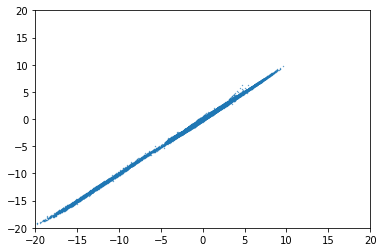

In [14]:
plt.scatter(y_pred_numpy.ravel(), Y_train.ravel(), s=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)

# Test set

In [15]:
y0_test = np.random.uniform(df_range['min'] + 0.3*df_range['span'],
                           df_range['max'] - 0.3*df_range['span'], 
                           size=(5000, nvar+1))

y0_list.shape

(5000, 75)

In [16]:
%time y1_test = kpp.onestep(y0_test.T).T

CPU times: user 3.74 s, sys: 39.5 ms, total: 3.78 s
Wall time: 3.72 s


In [17]:
X_test = np.append(normalizer.transform(y0_test[:,0:74]), 
                   y0_test[:,-1:], 
                   axis=1)
Y_test = normalizer.transform(y1_test)

In [18]:
%%time
X_torch_test = Variable(torch.from_numpy(X_test).type(torch.FloatTensor))
y_test_pred = model(X_torch_test).data.numpy()

CPU times: user 14.9 ms, sys: 3.08 ms, total: 18 ms
Wall time: 10.3 ms


In [19]:
r2_score(y_test_pred, Y_test)

0.9789151055627332

(-20, 20)

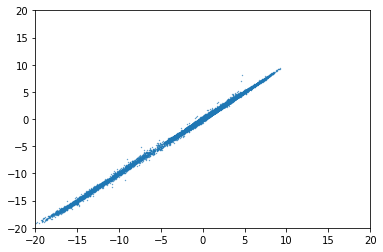

In [20]:
plt.scatter(y_test_pred, Y_test, s=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)

(-20, 20)

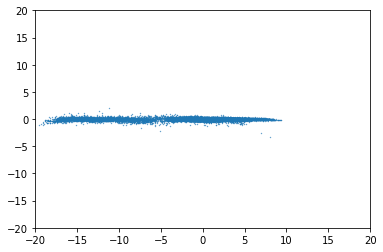

In [21]:
plt.scatter(Y_test, y_test_pred-Y_test, s=0.1)
plt.xlim(-20,20)
plt.ylim(-20,20)